# Air quality sensor data analysis with pandas

## Pandas and python for data analysis

The python pandas library provides powerful tools to analyse data. Specifically, we are trying to explore air quality data that has been captured in one of the official Munich pollution measurement station located in Lothstr. This is the reference data provided by the Bavarian State Office for the Environment: 

https://www.lfu.bayern.de/luft/immissionsmessungen/messwerte/index.htm

This is our first attempt at trying to explre meaningfully the captured pollution data using pandas.

## Air quality data exploratory analysis
Read sensor data from a set of csv files, appending them to obtain a panda time series

In [1]:
import os
import glob
import colorama
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.interpolate as interpolate
import seaborn as sns

In [2]:
def print_warning(msg):
    print(colorama.Fore.BLACK + colorama.Back.YELLOW + colorama.Style.BRIGHT
          + "WARNING: " + msg + colorama.Style.RESET_ALL)

In [6]:
# Analysis performed for data of a given pollutant type in a specific location.
SENSOR_LOC = 'lothstr'
SENSOR_TYPE = 'NO2'

# csv data file expected in current directory.
f_names = glob.iglob(os.path.join(os.getcwd(), 'sensor_{0:s}_{1:s}_*.csv'.format(SENSOR_LOC, SENSOR_TYPE)))

# List of dataframes, one per csv file. Each csv file corresponds to a different time interval of the
# given pollutant concentration data.
dfs = [pd.read_csv(f, sep=';', names=['date', 'time', 'pollutant_concentration'], dayfirst = True,
                   parse_dates={'datetime':['date','time']}, index_col='datetime') for f in f_names]

# Concatenate dataframes into a single datetime-sorted dataframe.
df = pd.concat(dfs).sort_index()

# Drop rows with duplicated DatetimeIndex, keeping only the first row.
num_duplicates = sum(df.index.duplicated())
if num_duplicates:
    print_warning('Found {0:d} duplicated datetime index!'.format(num_duplicates))
    df = df[~df.index.duplicated(keep='first')]

# Add hour into the week column from DatetimeIndex.
df['hour_into_week'] = df.index.hour + (24 * df.index.weekday)

# Add week offset column from DatetimeIndex.
df['week_offset'] = df.index.weekofyear  - df.index[0].weekofyear + 52 * ((df.index - pd.offsets.Week(weekday=6)).year - (df.index[0] - pd.offsets.Week(weekday=6)).year)

# Convert to table with one column per week of data and one row per hour in the week
df_weekly = pd.pivot_table(df, index=['hour_into_week'], columns=['week_offset'], values=['pollutant_concentration'])

# Add hourly mean concentration column.
df_weekly['hourly_mean'] = df_weekly.mean(axis=1)

# Add day of week column (0: Monday .. 6: Sunday).
df_weekly['day_of_week'] = (df_weekly.index / 24).astype(int)

# Hourly average series
meanval_hourly = df_weekly['hourly_mean']

# spline object to plot a smooth meanval_hourly.
x_smooth = np.linspace(0, len(meanval_hourly), 500)
t, c, k = interpolate.splrep(np.arange(0, len(meanval_hourly)), meanval_hourly, s=0, k=4)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

# Obtain series with daily average data, duplicating last value to improve visualization.
meanval_daily = df_weekly.groupby(['day_of_week']).mean()['hourly_mean']
meanval_daily.at[len(meanval_daily)] = meanval_daily.iloc[-1]
x_steps = np.linspace(0, len(df_weekly), len(meanval_daily))


### Hourly and daily average over all weeks in measurement period
*meanval_hourly* is a time series with hourly concentration averaged over each week of the measurement period, which covers from the 1st of January 2017 to the 10th of March 2018, while *meanval_daily* is a time series with 24-hour average daily concentration over the same measurement period.

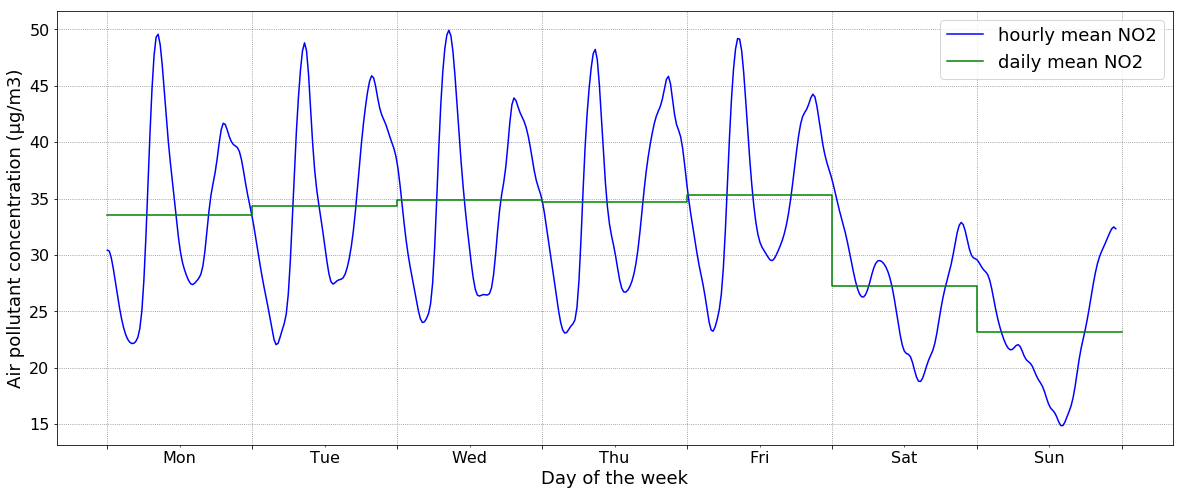

In [7]:
# Visualization of hourly and daily averages in a single plot.
fig, ax = plt.subplots(figsize=(20, 8))

# Plot hourly mean concentration (interpolated) in one week span.
ax.plot(x_smooth, spline(x_smooth), color='b', label='hourly mean NO2')

# Overlay the daily mean concentration step plot.
ax.step(x_steps, meanval_daily, color='g', where='post', label='daily mean NO2')

ax.set_xlabel("Day of the week", fontsize=18)
ax.set_ylabel("Air pollutant concentration (μg/m3)", fontsize=18)
plt.xticks(np.arange(0, 1 + 24*7, step=24))
plt.yticks(fontsize=16)
plt.legend(prop={'size': 18}, loc='best')
ax.xaxis.grid(color='gray', linestyle=':')
ax.yaxis.grid(color='gray', linestyle=':')

# Hide major tick labels.
ax.set_xticklabels('')

# Customize minor tick labels.
ax.set_xticks(np.arange(12, 12 + 24*7, step=24), minor=True)
_ = ax.set_xticklabels(('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), fontsize=16, minor=True)

### Daily view

Visualization of the whole set of measurements for a specific day of the week.

In [9]:
df_daily = [g for n, g in df.groupby(pd.Grouper(freq='D'))]

for d in df_daily:
    d['day_of_week'] = d.index.weekday_name
    d.index = map(lambda x: x.time(), d.index)

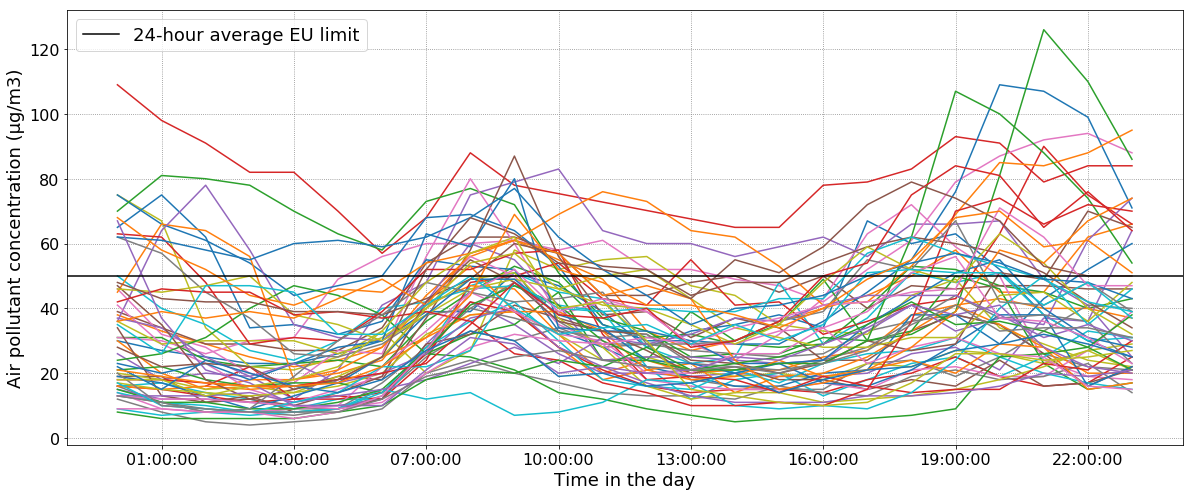

In [10]:
# Visualization.
fig, ax = plt.subplots(figsize=(20, 8))

ax.set_xlabel("Time in the day", fontsize=18)
ax.set_ylabel("Air pollutant concentration (μg/m3)", fontsize=18)
plt.xticks(df_daily[0].index[::3], fontsize=16)
plt.yticks(fontsize=16)

for d in df_daily:
    if d['day_of_week'][0] == 'Tuesday':
        d['pollutant_concentration'].plot(ax=ax, label='')

ax.axhline(y=50, color='black', linestyle='-', label='24-hour average EU limit')
plt.legend(prop={'size': 18}, loc='best')
ax.xaxis.grid(color='gray', linestyle=':')
ax.yaxis.grid(color='gray', linestyle=':')

In [11]:
# Number of days where the 24-hour average EU limit has been exceeded.

### Long term trends

In [12]:
# TODO